# Behavior Cloning Project
The objectives of this project are to capture training data using a simulator and clone the users steering angle behavior in the provided simulator

In [1]:
# Import Required Modules
import csv
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import math
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, Lambda, MaxPooling2D, Dropout, Cropping2D, Activation
import keras.backend.tensorflow_backend as K
from keras.optimizers import SGD, Adam, RMSprop
import keras
from keras.models import load_model


# If set to false Train from scratch else train 
# on small data that augments model
augment  = False

Using TensorFlow backend.


In [2]:
# define width and height This will be used to resize the image during training
new_size_col,new_size_row = 320, 160

labels = []
if augment is True:
    log_path = '../../data_aug/driving_log.csv'
else:
    log_path = '../../data_raw/driving_log.csv'
with open(log_path) as file:
    for label in file:
        labels.append(label)

In [3]:
# Augment image by randomly scaling Brightnesss
def brightness_random(input_image):
    # Convert image to HSV so that brightness can 
    # be adjusted by just the Value channel
    output_image = cv2.cvtColor(input_image,cv2.COLOR_RGB2HSV)
   
    # Draw a random Value so that brightness can be scaled
    scale = 0.5
    random_value = np.random.uniform(1. - scale,1. + scale)
    
    # Change value while retaining hue and saturation and clip after scaling
    output_image[:,:,2] = np.clip(output_image[:,:,2]*random_value, 0, 255)    
    
    # Reconvert to RGB 
    output_image = cv2.cvtColor(output_image,cv2.COLOR_HSV2RGB)
    
    return output_image


In [4]:
# Augment image by translating in both axes by random values

def translate_random(input_image,steering_value):
    # Translation max range is 80 pixels.
    # We will not translate image in y axis since
    # it does not impact steering value
    translation_max = 120
    
    # Pick a random number between -0.5,0.5 
    translation = np.random.uniform(-0.45,0.45)
    # Calculate random translation in pixel value 
    x_translation = translation_max*translation
    # Calculate change in steering angle
    new_steering = steering_value + translation
   
    # shift the image in x axis based on calculated translation
    transformation_matrix = np.float32([[1,0,x_translation],
                                        [0,1,0]])
    output_image = cv2.warpAffine(input_image,transformation_matrix,(input_image.shape[1],input_image.shape[0]))
    
    # return both translated image and the steering value
    return output_image,new_steering

In [5]:
def rescaleImage(image):
    # Resize the image
    image = cv2.resize(image,(new_size_col,new_size_row), interpolation=cv2.INTER_AREA)
    return image

In [6]:
def preprocess_image_for_training(data,label):
    # Input the data by reading image from file system and the steering value from argument
    steering = label
    image = cv2.imread(data)
    image = np.array(brightness_random(image))
    image,steering = translate_random(image,steering)
    image = rescaleImage(image)
    
    # Only flip center images randomly
    # I'm not going to flip the left and right images because
    # the additive inversion of the steering value 
    # does not hold true for right and left images
    to_flip = np.random.randint(0,10)%2
    if 'center' in data and to_flip==1:
        image = cv2.flip(image,1)
        steering = -1.0*steering
    
    return image,steering

In [7]:
# read and resize the image during validation
def preprocess_image_for_validation(data):
    image = cv2.imread(data) 
    return np.array(rescaleImage(image))

# Generator for Validation
def validation_generator_function(features,labels):
    while 1:
        for i in range(len(features)):
            data = features[i]
            label = labels[i]
            x = preprocess_image_for_validation(data)
            x = x.reshape(1, x.shape[0], x.shape[1], x.shape[2])
            y = np.array([[label]])
            
            yield x, y
            

In [8]:
# Generator for Training
def training_generator_function(data,labels,batch_size = 32):    
    
    # Create batch tensors
    batch_data = np.zeros((batch_size, new_size_row, new_size_col, 3))
    batch_labels = np.zeros(batch_size)
    while 1:
        for i in range(batch_size):
            random_index = np.random.randint(len(data))
            data_point = data[random_index]
            label_point = labels[random_index]
            # Preprocess image for training
            x,y = preprocess_image_for_training(data_point,label_point)
            batch_data[i] = x
            batch_labels[i] = y
        yield batch_data, batch_labels

In [9]:
features = []
values = []

index = 0 
for label in labels[1:]:
    #-17,-9,-1
    center = label.split('/')[-3].split(',')[0]
    left = label.split('/')[-2].split(',')[0]
    right = label.split('/')[-1].split(',')[0]
    if augment is False:
        path = '../../data_raw/IMG/'
    else:
        path = '../../data_aug/IMG/'
    
    image_center = path + center
    image_left = path + left
    image_right =  path + right 
    
    
    steering_value = float(label.split('/')[-1].split(',')[1])
    steering_compensation = 0.10 + (steering_value*steering_value)/0.5
    throttle_value = float(label.split('/')[-1].split(',')[4])

    if (throttle_value <= 7.5):
        continue

    steering_compensated_left = steering_value + steering_compensation
    steering_compensated_right = steering_value - steering_compensation
    
    features.append(image_left)
    values.append(steering_compensated_left)

    features.append(image_right)
    values.append(steering_compensated_right)  

    features.append(image_center)
    values.append(steering_value)

In [10]:
print ('Total number of data points', len(values))

Total number of data points 23244


In [11]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(np.array(features), 
                                                      np.array(values),
                                                      test_size=0.33,
                                                      random_state=42)
# assign the validation generator function
validation_generator = validation_generator_function(X_valid, y_valid)

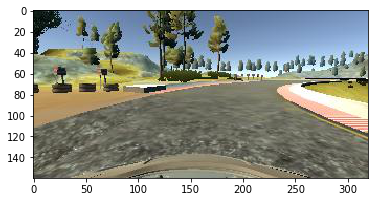

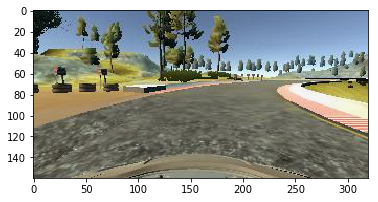

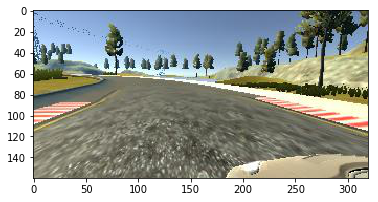

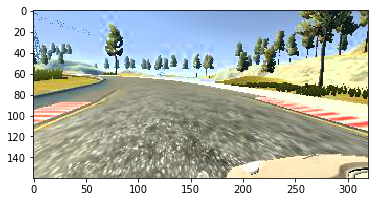

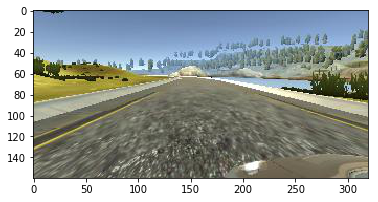

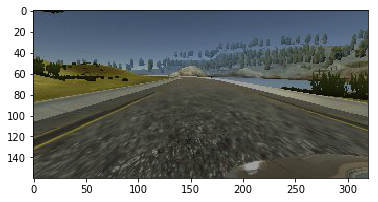

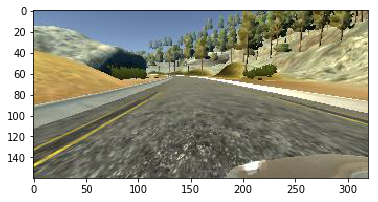

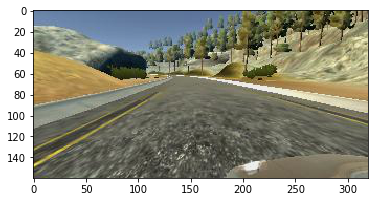

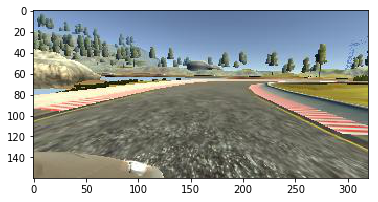

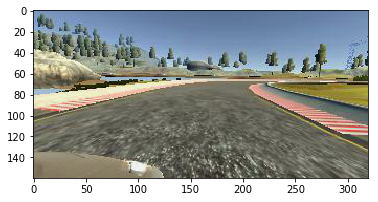

In [12]:
# Test image brightness scaling
for i in range(5):
    rand_ind =  np.random.randint(0,len(X_train))
    rand_img = cv2.imread(X_train[rand_ind])
    rand_img = cv2.cvtColor(rand_img,cv2.COLOR_BGR2RGB)
    plt.imshow(rand_img)
    plt.show()
    plt.imshow(brightness_random(rand_img),cmap='gray')
    plt.show()

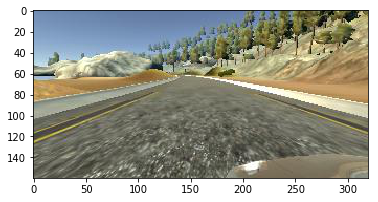

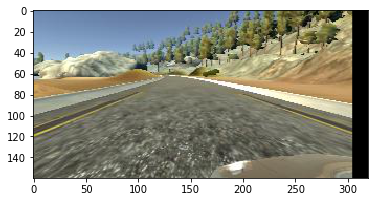

0.0403400115847 -0.0829937803214


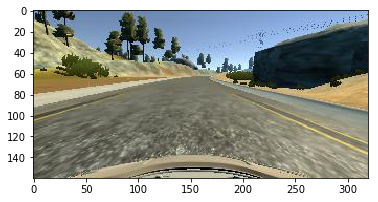

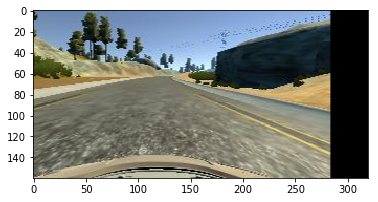

0.0 -0.296967787393


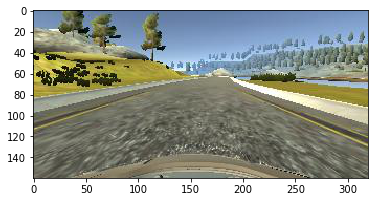

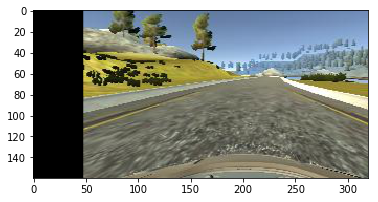

0.0 0.401991031391


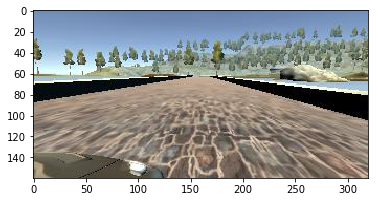

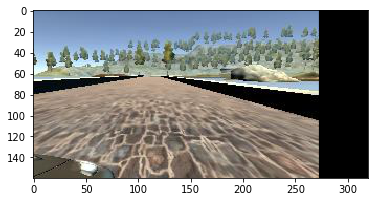

-0.1 -0.492502920095


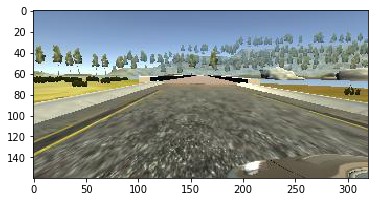

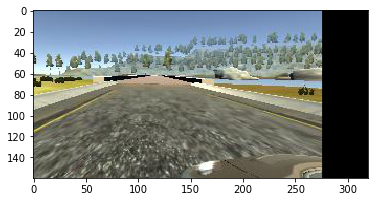

0.1 -0.265927186885


In [13]:
# Test random translation
for i in range(5):
    rand_ind =  np.random.randint(0,len(X_train))
    rand_img = cv2.imread(X_train[rand_ind])
    rand_img = cv2.cvtColor(rand_img,cv2.COLOR_BGR2RGB)
    plt.imshow(rand_img,cmap='gray')
    plt.show()
    out_img,steer = translate_random(rand_img,y_train[rand_ind])
    plt.imshow(out_img,cmap = 'gray')
    plt.show()
    print(y_train[rand_ind], steer)

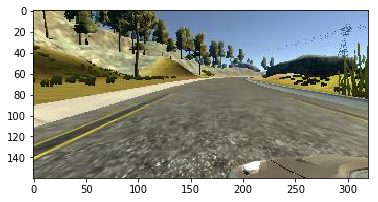

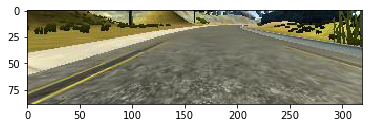

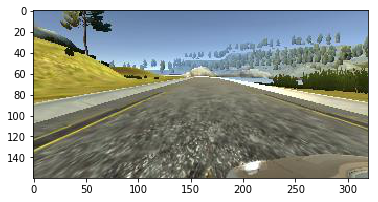

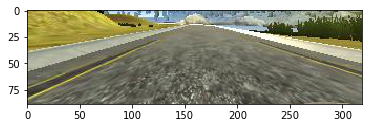

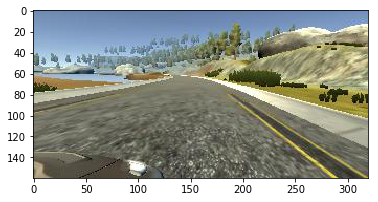

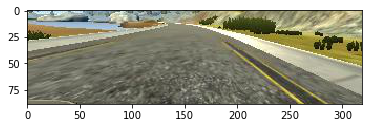

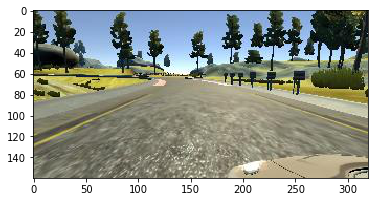

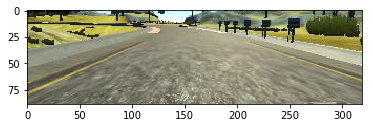

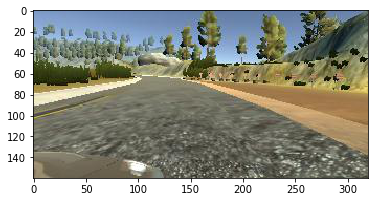

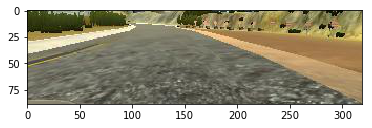

In [14]:
# Test image Cropping
crop_from_top = 50
crop_from_bottom = 20
for i in range(5):
    rand_ind =  np.random.randint(0,len(X_train))
    rand_img = cv2.imread(X_train[rand_ind])
    rand_img = cv2.cvtColor(rand_img,cv2.COLOR_BGR2RGB)
    plt.imshow(rand_img,cmap='gray')
    plt.show()
    out_img = rand_img[crop_from_top:rand_img.shape[0] - 1 - crop_from_bottom,
                       0:rand_img.shape[1] - 1]
    plt.imshow(out_img,cmap = 'gray')
    plt.show()

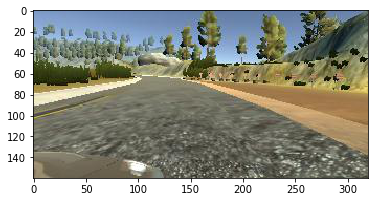

In [15]:
plt.imshow(rescaleImage(rand_img))

In [16]:
def nvidia_model():
    bc_model = Sequential()
    # Normalize the images in the model as per rubric requirement
    bc_model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(new_size_row,new_size_col,3)))
    bc_model.add(Cropping2D(cropping=((crop_from_top,crop_from_bottom), (0,0))))

    bc_model.add(Conv2D(24, 5,5, subsample = (2,2), activation='relu'))
    bc_model.add(Conv2D(36, 5,5, subsample = (2,2), activation='relu' ))
    bc_model.add(Conv2D(48, 5,5, subsample = (2,2), activation='relu'))
    bc_model.add(Conv2D(64,3,3, activation='relu'))
    bc_model.add(Conv2D(64,3,3, activation='relu'))
    bc_model.add(Flatten())
    bc_model.add(Dense(100))
    bc_model.add(Dropout(0.5))
    bc_model.add(Dense(50))
    bc_model.add(Dropout(0.5))
    bc_model.add(Dense(10))
    bc_model.add(Dropout(0.5))
    bc_model.add(Dense(1))
    return bc_model

In [17]:
# Using the Nvidia network. Tried to tune my own network but I got no success
# Future work: I'll try and give alex net and VGG a shot for this
if augment is False:    
    bc_model = nvidia_model()
else:
    bc_model = model = load_model('model.h5')
bc_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 160, 320, 3)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
cropping2d_1 (Cropping2D)        (None, 90, 320, 3)    0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 43, 158, 24)   1824        cropping2d_1[0][0]               
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 20, 77, 36)    21636       convolution2d_1[0][0]            
___________________________________________________________________________________________

In [18]:
# Compile and fit the model
bc_model.compile(loss='mse',optimizer='adam')
batch_size = 512
num_samples =  int(len(X_train)/(batch_size))*batch_size

filepath="model-{epoch:02d}-{val_loss:.2f}.h5"

# Save all the models. 
checkpoint = keras.callbacks.ModelCheckpoint(filepath, verbose=1, save_best_only=False, mode='max')
# Create logs for tensorboard
checkpoint2 = keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=True)
callbacks_list = [checkpoint, checkpoint2]

# Fit the model
history_object = bc_model.fit_generator(training_generator_function(X_train,y_train, batch_size),
                    samples_per_epoch= num_samples,
                    nb_epoch=3,
                    validation_data=validation_generator,
                    nb_val_samples = len(y_valid)/4,
                    verbose=1,
                    callbacks=callbacks_list)



# bc_model.save('simple_model.h5')

Epoch 1/3
15360/15360 [==============================] - 182s - loss: 0.0597 - val_loss: 0.0210
Epoch 2/3
15360/15360 [==============================] - 84s - loss: 0.0474 - val_loss: 0.0206
Epoch 3/3
15360/15360 [==============================] - 62s - loss: 0.0487 - val_loss: 0.0196


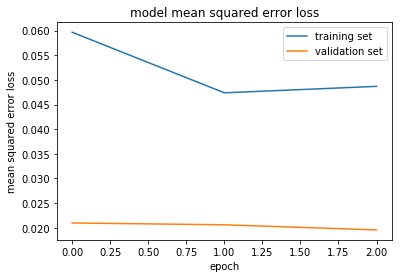

In [19]:
# Plot Training and Validation losses
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()